In [1]:
import os
from pathlib import Path
os.chdir(Path.cwd().parent)
# print("cwd is now:", Path.cwd())

In [2]:
%pip install plotly
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from data_loader import scores_df
from fit import fit_statistical_model


[notice] A new release of pip is available: 25.0 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
null performances after coercion: 281
after saturation filter 2201
after filter num benchmarks 1401
after merge with model versions 1397
after merge with benchmark dates 1397
Original number of rows: 1397
Number of rows after aggregation: 967


In [3]:
anchor_mode = "benchmark" # "model", "benchmark"
anchor_benchmark = "Winogrande"
anchor_difficulty = 0
anchor_slope = 1
anchor_model1 = "claude-2.0"
anchor_model1_capability = 1.263943
anchor_model2 = "claude-3-opus-20240229"
anchor_model2_capability = 1.510032

df1, df_cm1, df_db1 = fit_statistical_model(
    scores_df,
    anchor_mode=anchor_mode,
    anchor_benchmark=anchor_benchmark,
    anchor_difficulty=anchor_difficulty,
    anchor_slope=anchor_slope,
    anchor_model1=anchor_model1,
    anchor_model1_capability=anchor_model1_capability,
    anchor_model2=anchor_model2,
    anchor_model2_capability=anchor_model2_capability
)

df_cm1['date_obj'] = pd.to_datetime(df_cm1['date'])

`ftol` termination condition is satisfied.
Function evaluations 22, initial cost 3.4441e+01, final cost 2.4399e+00, first-order optimality 3.83e-04.


In [4]:
ref_models = [
'claude-2.0', 
'claude-3-opus-20240229',
'claude-3-7-sonnet-20250219_64K',
'claude-3-5-sonnet-20241022',
'claude-3-5-sonnet-20240620',
'claude-opus-4-20250514_16K',
'o1-2024-12-17_high',
'o1-mini-2024-09-12_high',
'o3-2025-04-16_high',
'o3-mini-2025-01-31_high',
'o4-mini-2025-04-16_high',
'text-davinci-001',
'text-davinci-002',
'gpt-4-0613',
'gpt-4o-2024-11-20',
'gpt-4o-mini-2024-07-18',
'gpt-4.5-preview-2025-02-27',
'gpt2-xl',
]

df_cm1[df_cm1["model"].isin(ref_models)][["model", "estimated_capability"]]

,model,estimated_capability
110,o3-2025-04-16_high,2.406364
111,o4-mini-2025-04-16_high,2.358387
88,o3-mini-2025-01-31_high,2.212854
90,o1-2024-12-17_high,2.202170
116,claude-opus-4-20250514_16K,2.172372
122,claude-3-7-sonnet-20250219_64K,2.133332
89,o1-mini-2024-09-12_high,2.047956
95,gpt-4.5-preview-2025-02-27,1.995364
140,claude-3-5-sonnet-20241022,1.877831
23,claude-3-5-sonnet-20240620,1.741889


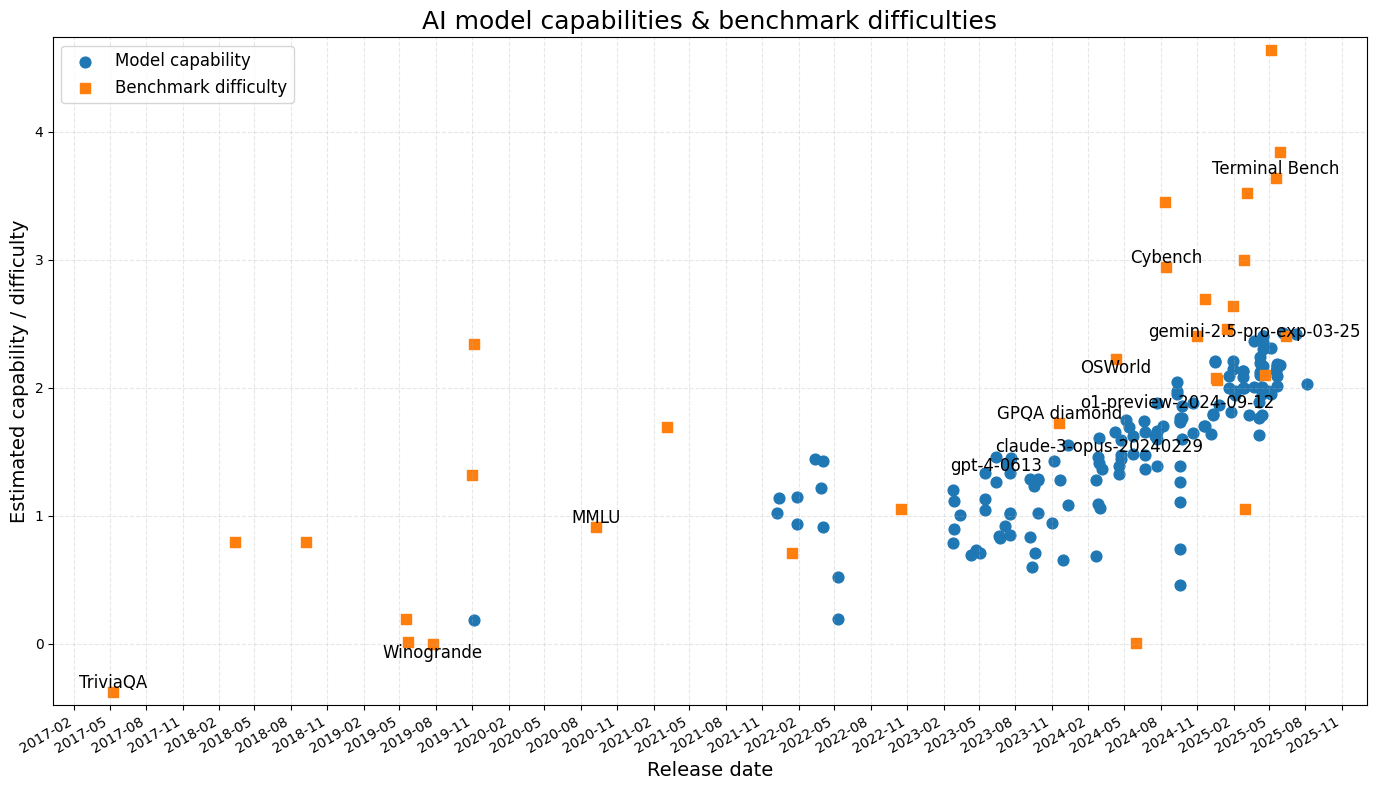

In [5]:
# ── 1)  PREP THE TWO DATA SETS ────────────────────────────────────────────
# --- models / capabilities
cap_df = df_cm1.copy()
cap_df["date_obj"] = pd.to_datetime(cap_df["date_obj"])
cap_df.sort_values("date_obj", inplace=True, ignore_index=True)
cap_dates_num = mdates.date2num(cap_df["date_obj"])
cap_values    = cap_df["estimated_capability"]

# --- benchmarks / difficulties
bench_df = df_db1.copy()
bench_df["date_obj"] = pd.to_datetime(bench_df["benchmark_release_date"])
bench_df.sort_values("date_obj", inplace=True, ignore_index=True)
bench_dates_num = mdates.date2num(bench_df["date_obj"])
bench_values    = bench_df["estimated_difficulty"]

# ── 2)  PLOT BOTH SERIES ON ONE AXES ───────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 8))

cap_plot   = ax.scatter(cap_dates_num,   cap_values,
                        marker='o', s=60, color='tab:blue',  label='Model capability')
bench_plot = ax.scatter(bench_dates_num, bench_values,
                        marker='s', s=60, color='tab:orange', label='Benchmark difficulty')

# ── 3)  ANNOTATE SELECTED POINTS ───────────────────────────────────────────
annotate_models = {
    "gpt-4-0613",
    "claude-3-opus-20240229",
    "gemini-2.5-pro-exp-03-25",
    "o1-preview-2024-09-12",
}

for i, (d, y, name) in enumerate(zip(cap_dates_num, cap_values, cap_df["model"])):
    if name not in annotate_models:
        continue
    y_offset  = 0.05 if i % 2 == 0 else -0.05
    va        = 'bottom' if i % 2 == 0 else 'top'
    ax.annotate(name, xy=(d, y), xytext=(0, y_offset),
                textcoords='offset points', ha='center', va=va, fontsize=12)

annotate_benchmarks = {
    "MMLU",
    "Winogrande",
    "GPQA diamond",
    "OSWorld",
    "Cybench",
    "Terminal Bench",
    "TriviaQA",
}

for i, (d, y, name) in enumerate(zip(bench_dates_num, bench_values, bench_df["benchmark_name"])):
    if name not in annotate_benchmarks:
        continue
    y_offset  = 0.05 if i % 2 == 0 else -0.05
    va        = 'bottom' if i % 2 == 0 else 'top'
    ax.annotate(name, xy=(d, y), xytext=(0, y_offset),
                textcoords='offset points', ha='center', va=va, fontsize=12)

# ── 4)  AXES COSMETICS & LEGEND ────────────────────────────────────────────
ax.set_xlabel("Release date",  fontsize=14)
ax.set_ylabel("Estimated capability / difficulty", fontsize=14)
ax.set_title("AI model capabilities & benchmark difficulties", fontsize=18)

# date ticks every 3 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
fig.autofmt_xdate()

# y-range covers both series
min_y = min(cap_values.min(),  bench_values.min()) - 0.1
max_y = max(cap_values.max(),  bench_values.max()) + 0.1
ax.set_ylim(min_y, max_y)

# x-range exactly as requested
# ax.set_xlim(datetime(2023, 1, 1), datetime(2025, 7, 1))

ax.grid(True, linestyle='--', alpha=0.3)
ax.legend(fontsize=12)

plt.tight_layout()
plt.savefig("capabilities_and_benchmarks_over_time.pdf")
plt.show()


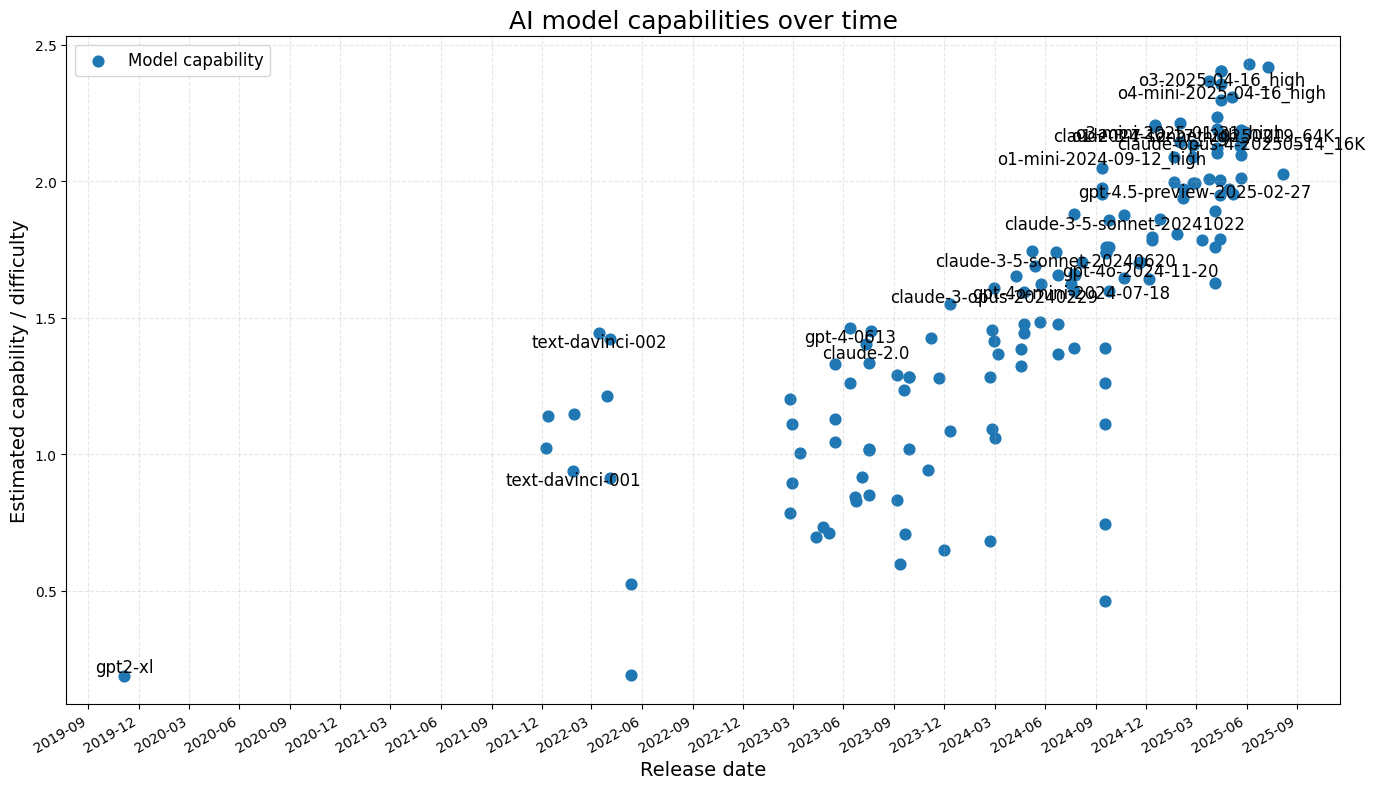

In [6]:
# ── 1)  PREP THE TWO DATA SETS ────────────────────────────────────────────
# --- models / capabilities
cap_df = df_cm1.copy()
cap_df["date_obj"] = pd.to_datetime(cap_df["date_obj"])
cap_df.sort_values("date_obj", inplace=True, ignore_index=True)
cap_dates_num = mdates.date2num(cap_df["date_obj"])
cap_values    = cap_df["estimated_capability"]

# --- benchmarks / difficulties
bench_df = df_db1.copy()
bench_df["date_obj"] = pd.to_datetime(bench_df["benchmark_release_date"])
bench_df.sort_values("date_obj", inplace=True, ignore_index=True)
bench_dates_num = mdates.date2num(bench_df["date_obj"])
bench_values    = bench_df["estimated_difficulty"]

# ── 2)  PLOT BOTH SERIES ON ONE AXES ───────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 8))

cap_plot   = ax.scatter(cap_dates_num,   cap_values,
                        marker='o', s=60, color='tab:blue',  label='Model capability')
# bench_plot = ax.scatter(bench_dates_num, bench_values,
#                         marker='s', s=60, color='tab:orange', label='Benchmark difficulty')

# ── 3)  ANNOTATE SELECTED POINTS ───────────────────────────────────────────
annotate_models = {
    "gpt-4-0613",
    "claude-3-opus-20240229",
    "gemini-2.5-pro-exp-03-25",
    "o1-preview-2024-09-12",
}

for i, (d, y, name) in enumerate(zip(cap_dates_num, cap_values, cap_df["model"])):
    if name not in ref_models:
        continue
    y_offset  = 0.05 if i % 2 == 0 else -0.05
    va        = 'bottom' if i % 2 == 0 else 'top'
    ax.annotate(name, xy=(d, y), xytext=(0, y_offset),
                textcoords='offset points', ha='center', va=va, fontsize=12)

# ── 4)  AXES COSMETICS & LEGEND ────────────────────────────────────────────
ax.set_xlabel("Release date",  fontsize=14)
ax.set_ylabel("Estimated capability / difficulty", fontsize=14)
ax.set_title("AI model capabilities over time", fontsize=18)

# date ticks every 3 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
fig.autofmt_xdate()

# y-range covers both series
min_y = cap_values.min() - 0.1
max_y = cap_values.max() + 0.1
ax.set_ylim(min_y, max_y)

# x-range exactly as requested
# ax.set_xlim(datetime(2023, 1, 1), datetime(2025, 7, 1))

ax.grid(True, linestyle='--', alpha=0.3)
ax.legend(fontsize=12)

plt.tight_layout()
plt.savefig("capabilities_over_time.pdf")
plt.show()


Bootstrapped mean rate: 0.4206 capability units/year
95% confidence interval: [0.3590, 0.5002]


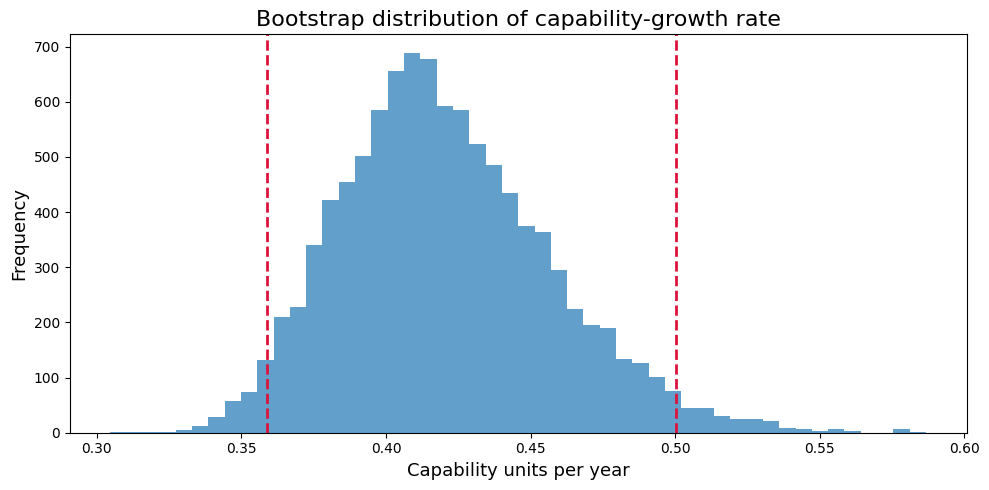

In [7]:
n_boot      = 10000          # number of bootstrap resamples
rng         = np.random.default_rng(0)   # reproducible seed

# x_full = cap_dates_num                       # days-since-0000-12-31 (float64)
# y_full = cap_values.to_numpy()         # capability values (float64)

mask = ~(np.isnan(cap_dates_num) | np.isnan(cap_values))
x_full = cap_dates_num[mask]
y_full = cap_values[mask]

boot_slopes_year = np.empty(n_boot)      # pre-allocate

for i in range(n_boot):
    # sample indices with replacement
    idx           = rng.choice(len(x_full), len(x_full), replace=True)
    slope_day, _  = np.polyfit(x_full[idx], y_full[idx], 1)
    boot_slopes_year[i] = slope_day * 365.25   # convert to per-year

# point estimate & 95 % CI
mean_rate = boot_slopes_year.mean()
ci_lower, ci_upper = np.percentile(boot_slopes_year, [2.5, 97.5])

print(f"Bootstrapped mean rate: {mean_rate:.4f} capability units/year")
print(f"95% confidence interval: [{ci_lower:.4f}, {ci_upper:.4f}]")

# ── (optional) visualise the bootstrap distribution ────────────────────
plt.figure(figsize=(10, 5))
plt.hist(boot_slopes_year, bins=50, alpha=0.7)
plt.axvline(ci_lower, color='crimson', linestyle='--', lw=2)
plt.axvline(ci_upper, color='crimson', linestyle='--', lw=2)
plt.title('Bootstrap distribution of capability-growth rate', fontsize=16)
plt.xlabel('Capability units per year', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.tight_layout()
plt.show()

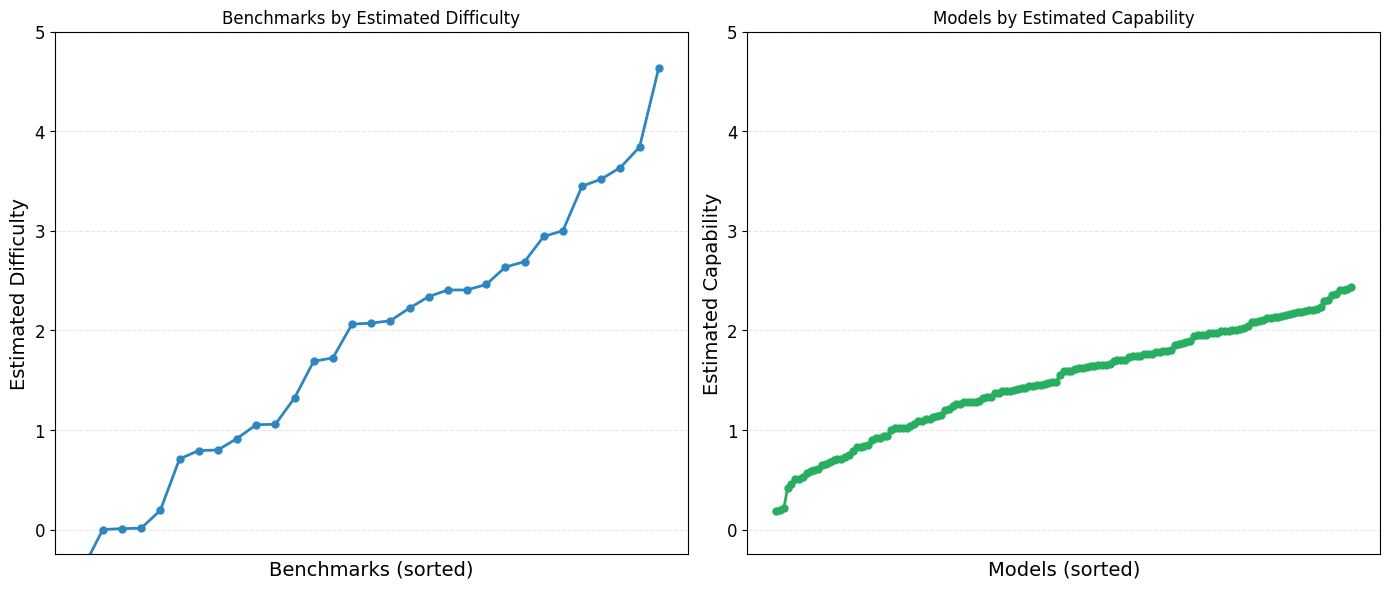

In [8]:
# ---------- 1) Prepare the two ordered data sets ----------
# ------------- (exactly as in your originals) -------------
sorted_bd = df_db1.sort_values(by="estimated_difficulty").reset_index(drop=True)
bd_values  = sorted_bd["estimated_difficulty"]
bd_names   = sorted_bd["benchmark_name"]
bd_ids     = sorted_bd["benchmark_id"]
bd_idx     = np.arange(len(bd_values))

sorted_cm = df_cm1.sort_values(by="estimated_capability").reset_index(drop=True)
cm_values  = sorted_cm["estimated_capability"]
cm_names   = sorted_cm["model"]
cm_ids     = sorted_cm["model_id"]
cm_idx     = np.arange(len(cm_values))

# ---------- 2) Create a single figure with two sub-axes ----------
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2, figsize=(14, 8), sharey=False  # sharey=False because scales differ
)

# ---------- 3) First subplot: benchmark difficulties ----------
ax1.plot(bd_idx, bd_values, marker='o', linestyle='-', linewidth=2,
         markersize=5, color='#2E86C1')
ax1.set_xlabel('Benchmarks (sorted)', fontsize=14)
ax1.set_ylabel('Estimated Difficulty', fontsize=14)
ax1.set_title('Benchmarks by Estimated Difficulty')
# ax1.set_xticks(bd_idx)
# ax1.set_xticklabels(bd_ids, rotation=90)
ax1.set_xticks([])
ax1.grid(True, alpha=0.3, linestyle='--')
# ax1.axhspan(bd_values.min(), bd_values.max(), alpha=0.1, color='skyblue')

ax1.set_ylim(-0.25, 5)
ax1.tick_params(axis='y', labelsize=12)

# # optional min / max call-outs
# ax1.annotate(f'Min: {bd_values.min():.2f}', xy=(0, bd_values.min()),
#              xytext=(10, 20), textcoords='offset points',
#              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'), fontsize=12)
# ax1.annotate(f'Max: {bd_values.max():.2f}', xy=(len(bd_values)-1, bd_values.max()),
#              xytext=(-50, -20), textcoords='offset points',
#              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'), fontsize=12)

# ---------- 4) Second subplot: model capabilities ----------
ax2.plot(cm_idx, cm_values, marker='o', linestyle='-', linewidth=2,
         markersize=5, color='#27AE60')
ax2.set_xlabel('Models (sorted)', fontsize=14)
ax2.set_ylabel('Estimated Capability', fontsize=14)
ax2.set_title('Models by Estimated Capability')
# ax2.set_xticks(cm_idx)
# ax2.set_xticklabels(cm_ids, rotation=90)
ax2.set_xticks([])
ax2.grid(True, alpha=0.3, linestyle='--')
# ax2.axhspan(cm_values.min(), cm_values.max(), alpha=0.1, color='lightgreen')

ax2.set_ylim(-0.25, 5)
ax2.tick_params(axis='y', labelsize=12)

# ax2.annotate(f'Min: {cm_values.min():.2f}', xy=(0, cm_values.min()),
#              xytext=(10, 20), textcoords='offset points',
#              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'), fontsize=12)
# ax2.annotate(f'Max: {cm_values.max():.2f}', xy=(len(cm_values)-1, cm_values.max()),
#              xytext=(-50, -20), textcoords='offset points',
#              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'), fontsize=12)

# ---------- 5) Finish up ----------
# fig.suptitle('Benchmark Difficulty vs. Model Capability', fontsize=16, y=0.98)
fig.tight_layout(rect=[0, 0, 1, 0.95])   # leave room for the suptitle
plt.subplots_adjust(bottom=0.25)         # extra space for x-tick labels


plt.savefig("model_and_benchmark_ranking.pdf")

plt.show()


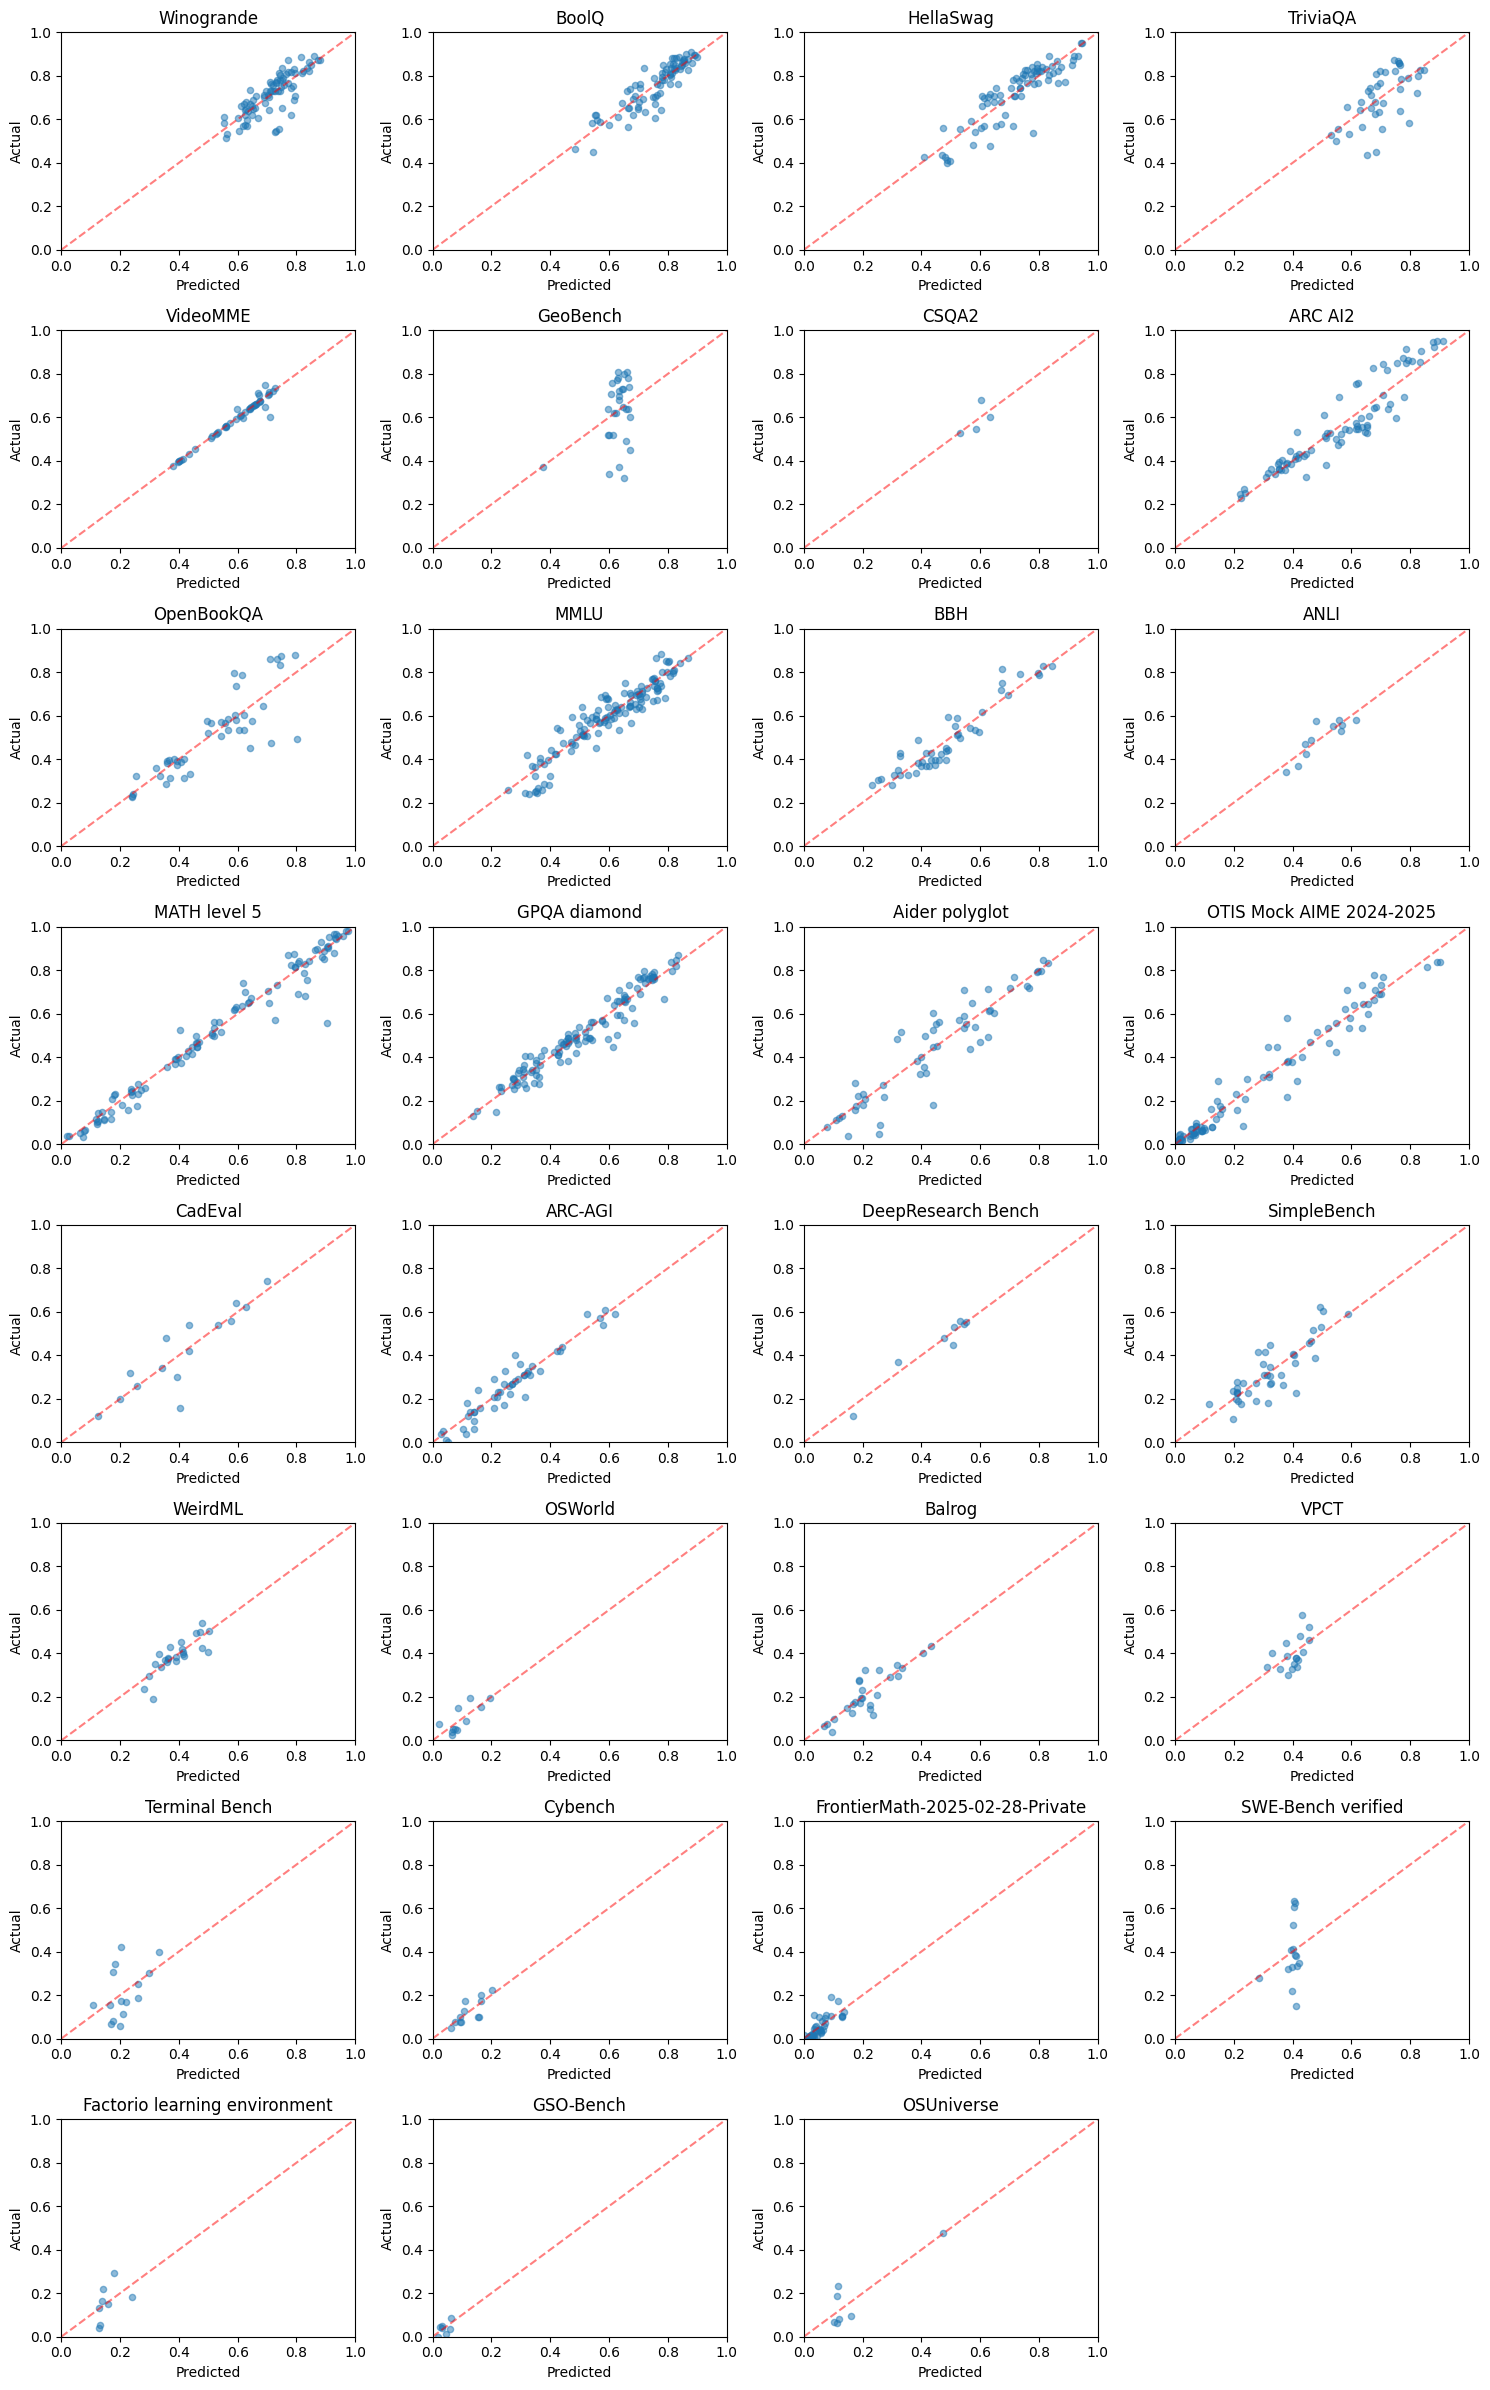

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def logistic(x):
    return 1.0 / (1.0 + np.exp(-x))

# Get unique benchmarks
benchmarks = df_db1['benchmark_name'].unique()

# Create subplots
n_benchmarks = len(benchmarks)
n_cols = 4
n_rows = (n_benchmarks + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))
axes = axes.flatten()

# Loop through each benchmark
for idx, benchmark in enumerate(benchmarks):
    ax = axes[idx]
    
    # Get data for this benchmark
    bench_data = df1[df1['benchmark'] == benchmark].copy()
    
    # Get benchmark parameters
    bench_params = df_db1[df_db1['benchmark_name'] == benchmark].iloc[0]
    D = bench_params['estimated_difficulty']
    alpha = bench_params['estimated_slope']
    
    # Merge with model capabilities
    bench_data = bench_data.merge(df_cm1[['model', 'estimated_capability']], on='model', how='left')
    
    # Calculate predicted performance
    bench_data['predicted'] = logistic(alpha * (bench_data['estimated_capability'] - D))
    
    # Plot
    ax.scatter(bench_data['predicted'], bench_data['performance'], alpha=0.5, s=20)
    ax.plot([0, 1], [0, 1], 'r--', alpha=0.5)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(benchmark)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

# Hide unused subplots
for idx in range(n_benchmarks, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

SOTA-at-release points: 17
Annual growth rate (slope): 0.3666
R^2: 0.9406
Span: 2019-11-05  2025-06-05


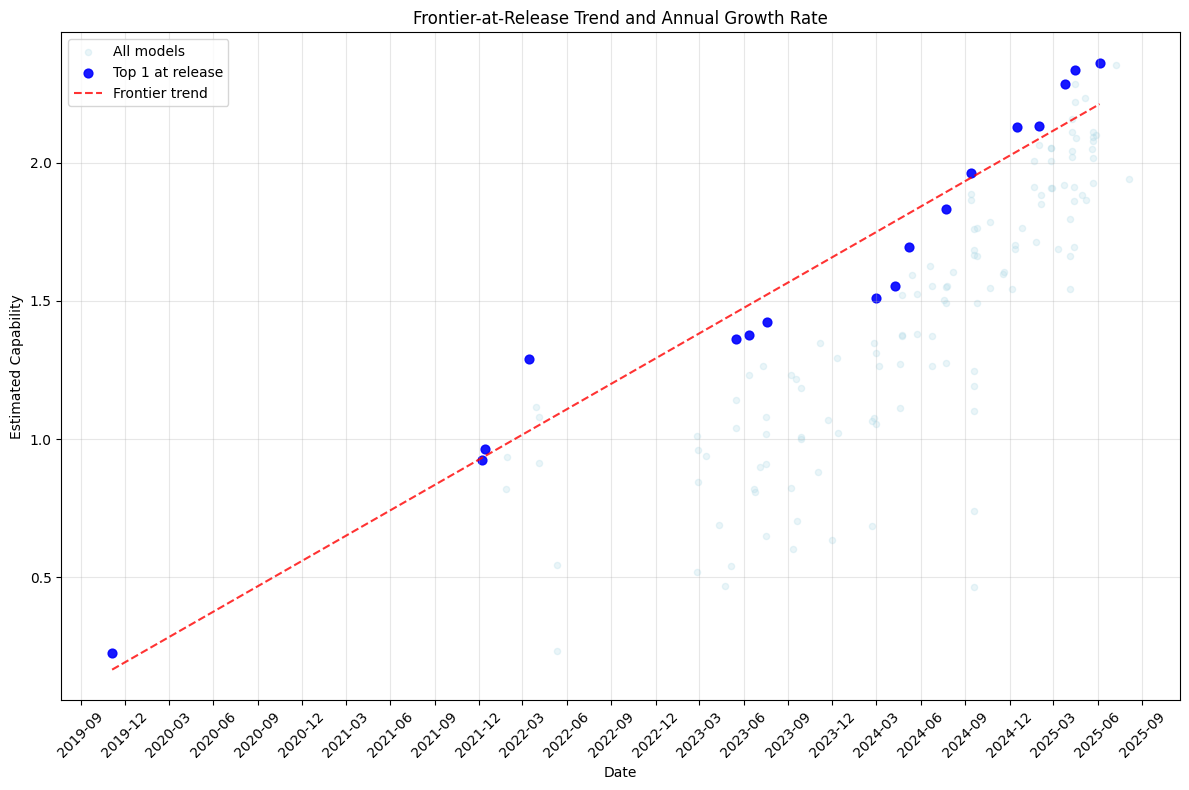

In [38]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Identify models that were SOTA (top-N) at their release and fit a trend
TOP_N_AT_RELEASE = 1  # change to >1 if you want top-N frontier, not strict SOTA

# Prepare data
df_all = df_cm1.copy()
# Ensure datetime
if 'date_obj' not in df_all.columns or not np.issubdtype(df_all['date_obj'].dtype, np.datetime64):
    df_all['date_obj'] = pd.to_datetime(df_all['date'])

df_all = df_all.dropna(subset=['date_obj', 'estimated_capability']).sort_values('date_obj').reset_index(drop=True)

# Compute frontier-at-release
frontier_rows = []
for _, row in df_all.iterrows():
    release_date = row['date_obj']
    available = df_all[df_all['date_obj'] <= release_date]
    top_at_release = available.nlargest(TOP_N_AT_RELEASE, 'estimated_capability')
    if row['model'] in top_at_release['model'].values:
        frontier_rows.append(row)

df_frontier = pd.DataFrame(frontier_rows).sort_values('date_obj').reset_index(drop=True)

# Fit linear trend through frontier points
if len(df_frontier) >= 2:
    X = (df_frontier['date_obj'] - df_frontier['date_obj'].min()).dt.days.values.reshape(-1, 1)
    y = df_frontier['estimated_capability'].values
    lr = LinearRegression()
    lr.fit(X, y)
    slope_per_year = lr.coef_[0] * 365.25
    r2 = lr.score(X, y)
else:
    lr = None
    slope_per_year = np.nan
    r2 = np.nan

print("SOTA-at-release points:", len(df_frontier))
print(f"Annual growth rate (slope): {slope_per_year:.4f}")
print(f"R^2: {r2:.4f}")
if len(df_frontier) > 0:
    print(f"Span: {df_frontier.iloc[0]['date']}  {df_frontier.iloc[-1]['date']}")

# Plot: all points, frontier points, and trendline
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(df_all['date_obj'], df_all['estimated_capability'], alpha=0.25, s=20, label='All models', color='lightblue')
ax.scatter(df_frontier['date_obj'], df_frontier['estimated_capability'], alpha=0.9, s=40, label=f'Top {TOP_N_AT_RELEASE} at release', color='blue')

if lr is not None:
    X_plot = (df_frontier['date_obj'] - df_frontier['date_obj'].min()).dt.days.values.reshape(-1, 1)
    y_pred = lr.predict(X_plot)
    ax.plot(df_frontier['date_obj'], y_pred, 'r--', alpha=0.8, label='Frontier trend')

ax.set_xlabel('Date')
ax.set_ylabel('Estimated Capability')
ax.set_title('Frontier-at-Release Trend and Annual Growth Rate')
ax.grid(True, alpha=0.3)
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
